In [1]:
import pandas as pd
import numpy as np
import re
import gensim
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud
from gensim import corpora, models, similarities
import pyLDAvis
from pprint import pprint
import pickle 
import os
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
import random
from gensim.models.ldamodel import LdaModel
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import MmCorpus
import csv
import pyLDAvis.gensim_models as gensimvis
RANDOM_STATE = 1

In [22]:
data = pd.read_csv('dataset/DatasetLegal.csv')
with open('model/id2word.pkl', 'rb') as f:
    id2word = pickle.load(f)
with open("lda/topic_dict_5.pkl", "rb") as f:
   topic_dict = pickle.load(f)
with open("lda/lda_model_5.pkl", "rb") as f:
    lda_model = pickle.load(f)
corpus_question = corpora.MmCorpus('corpus_question.mm')

str_answer = data['answer'].astype(str)
str_answer = str_answer.map(lambda x: re.sub('[,.!?*#/]', '', x))
str_question = data['question'].astype(str)
str_question = str_question.map(lambda x: re.sub('[,.!?*#/]', '', x))

train_answer = list(str_answer[:5625])
test_answer = list(str_answer[5625:])
train_question = list(str_question[:5625])
test_question = list(str_question[5625:])

In [23]:
def preprocess(text):
  stopwords = list(thai_stopwords())
  read_stopwords = pd.read_csv('dataset/add_stopwords.csv')
  add_stopwords = read_stopwords['stopword'].values.tolist()
  result = []
  str_text = str(text).replace(' ','')
  word_token = word_tokenize(str_text, engine='newmm')
  for word in word_token:
    if(word not in stopwords + add_stopwords):
      result.append(word)
  return result

def bow(text):
  vector = id2word.doc2bow(text)
  return vector

In [24]:
new_doc = random.choice(test_question)
test_doc = preprocess(new_doc)
test_doc = bow(test_doc)
# print(test_doc)
new_doc_topics = lda_model.get_document_topics(test_doc)
new_doc_topics_dict = {topic_dict[topic]: prob for topic, prob in new_doc_topics}
print(new_doc_topics_dict)

{'labor': 0.006175399, 'personal_right/court': 0.007730632, 'family/succession': 0.35306707, 'contract': 0.62829155, 'criminal': 0.0047354074}


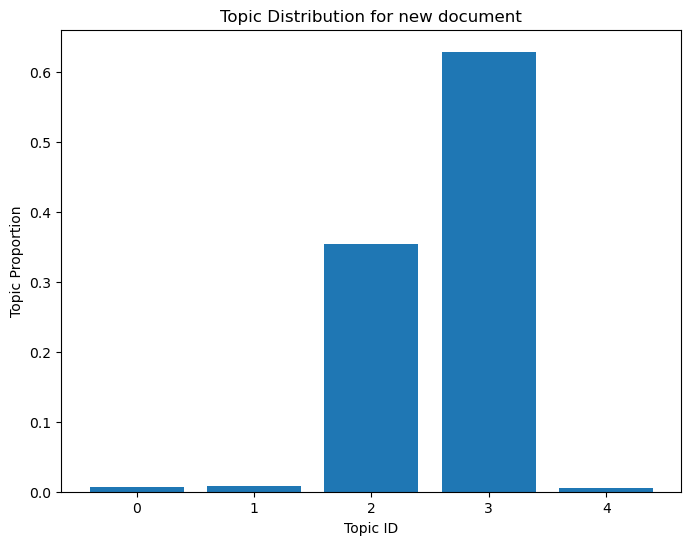

In [25]:
# plot the bar chart
plt.figure(figsize=(8,6))
plt.bar([t[0] for t in new_doc_topics], [t[1] for t in new_doc_topics])
plt.xlabel('Topic ID')
plt.ylabel('Topic Proportion')
plt.title(f'Topic Distribution for new document')
plt.show()

In [26]:
corpus_lda = lda_model[corpus_question]
index = similarities.MatrixSimilarity(corpus_lda, num_features=len(id2word))
sims = index[new_doc_topics]
sims_sorted = sorted(enumerate(sims), key=lambda item: -item[1])
print(f"Topic distribution for new document : {new_doc_topics}\n{new_doc}\n")
for doc_id, similarity in sims_sorted[:5]:
    print(f"Document ID: {doc_id}, Similarity score: {similarity}")
    print(data.answer[doc_id])
    print("Topic distribution for similar document : ")
    for num, dis in corpus_lda[doc_id]:
      print(f"\t({topic_dict.get(num)}, {'%.5f' %dis})")
    #print("\n")
    #print(f"Topic distribution for similar document : \n{corpus_lda[doc_id]}\n")

Topic distribution for new document : [(0, 0.006175399), (1, 0.007730632), (2, 0.35306707), (3, 0.62829155), (4, 0.0047354074)]
สามีมีหนี้จากบัตรเครดิตถ้าหย่ากับภรรยาๆต้องร่วมรับหนี้นี้ด้วยไหมหรือต้องมีการพิสูจน์ว่าได้ใช้ไปในครัวเรือนและยังชีพ

Document ID: 4764, Similarity score: 0.9999600648880005
เห็นว่าประมวลกฎหมายแพ่งและพาณิชย์มาตรา๑๔๗๐บัญญัติว่าสินส่วนตัวนั้นได้แก่ทรัพย์สิน๑ที่ฝ่ายหนึ่งฝ่ายใดมีอยู่ก่อนสมรสมาตรา๑๔๗๔สินสมรสนั้นได้แก่ทรัพย์สิน๑ที่คู่สมรสได้มาระหว่างสมรสเห็นว่าแม้ในปัจจุบันชื่อผู้ถือกรรมสิทธิ์ที่ดินเป็นของแฟนแต่อยู่ในระหว่างกำลังผ่อนชำระหนี้สินอยู่แต่เมื่อได้จดทะเบียนสมรสกันกว่าจะส่งชำระหนี้เงินค่าซื้อบ้านหมดถือว่าเป็นการร่วมกันสร้างทรัพย์สินด้วยกันขึ้นมาและเป็นสินสมรสแต่ท่านต้องขอมีชื่อร่วมเป็นเจ้าของกรรมสิทธิ์ด้วยต่างกับกรณีที่แฟนมีที่ดินมาก่อนและไม่มีการผ่อนส่งที่ดินดังกล่าวนั้นเป็นสินส่วนตัวของแฟนท่านท่านควรจะพูดคุยเรื่อนี้ให้เข้าใจกันให้ดีเพื่อจะไม่ขัดใจกันในครอบครัว
Topic distribution for similar document : 
	(labor, 0.00351)
	(personal_right/court, 0.00439)
	(